In [100]:
%reset-f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook demonstrates the usage of the resilience/socio-economic capacity model.

# Loading functions

We first import function librairies. The first ones are standard python librairies.

In [101]:
#The main library we use. Manipulates Excel-like tables (called dataframes) with named rows and columns
import pandas as pd 

In [102]:
#ploting capacities
import matplotlib.pyplot as plt 
#make plots appear in this notebook
%matplotlib inline  

#Default options for plots: this controls the font used in figures
font = {'family' : 'sans serif',
    'size'   : 18}
plt.rc('font', **font)


# Loading and exploring all the data

Here we read the whole data set we need into a pandas table (called DataFrame).
This specific dataset was put together from a variety of different sources using another python notebook: [data_gathering_demo.ipynb](data_gathering_demo.ipynb). In the future we could build directly an excel file with all the data the model needs.

In [103]:
 #Let's first have a look at the Excel file
pd.read_excel("all_data_compiled.xlsx").head();

We see that the Escel files srtat with one line of description, the second line is that actual variable name in the model, and the thirs line is empty. We also see that the first column is the name of each Province, which we will use to index the data.

In [104]:
#Load the excel data file into a dataframe (table)
df=pd.read_excel("all_data_compiled.xlsx", 
                 index_col=0, #tells Pandas to use the first column (Provinces) as the index of the table
                 skiprows=[0, 2] #The first (0) row is a description of the variables and the 3rd (2) row is empty. We skip them
                ) 
df.index.name="province"
#Displays the first rows of that dataframe
df.head()

,gdp_pc_pp,pop,pov_head,shew,gdp_pc_pp_nat,rel_gdp_pp,share1,axfin_p,axfin_r,social_p,...,v_r,protection,avg_prod_k,T_rebuild_K,pi,nat_buyout,sigma_r,sigma_p,income_elast,rho
province,,,,,,,,,,,,,,,,,,,,,
Abra,133.688,240135.244121,0.373595,0.953416,184.136685,0.726026,0.374005,0.693233,0.693233,0.408683,...,0.100000,10.57,0.23,3,0.2,0.3,0.333333,0.333333,1.5,0.05
Agusan Del Norte,179.014,661728.454375,0.346715,0.821277,184.136685,0.972180,0.279308,0.496880,0.496880,0.388003,...,0.100000,9.41,0.23,3,0.2,0.3,0.333333,0.333333,1.5,0.05
Agusan Del Sur,126.492,677779.682154,0.480785,0.821277,184.136685,0.686946,0.395282,0.475969,0.475969,0.388003,...,0.100000,8.61,0.23,3,0.2,0.3,0.333333,0.333333,1.5,0.05
Aklan,119.962,554414.442422,0.249662,0.823003,184.136685,0.651483,0.416799,0.660083,0.660083,0.432903,...,0.135089,2.00,0.23,3,0.2,0.3,0.333333,0.333333,1.5,0.05
Albay,158.629,1264097.894966,0.409587,0.800000,184.136685,0.861474,0.315201,0.551314,0.551314,0.403794,...,0.100000,2.00,0.23,3,0.2,0.3,0.333333,0.333333,1.5,0.05


The columns names correspond to variable in a model, so they are not all self-explanatory. For a description of the variables, see above, or [inputs/inputs_info.csv](inputs/inputs_info.csv)

Let's get familiar with Dataframes. Here is how to look at specific rows or columns.

In [105]:
df.ix["Abra"].head() #all the data we have on Abra. The head() method returns only the first few lines for saving space

gdp_pc_pp           133.688000
pop              240135.244121
pov_head              0.373595
shew                  0.953416
gdp_pc_pp_nat       184.136685
Name: Abra, dtype: float64

In [106]:
df["pop"].head() #population in all provinces

province
Abra                 240135.244121
Agusan Del Norte     661728.454375
Agusan Del Sur       677779.682154
Aklan                554414.442422
Albay               1264097.894966
Name: pop, dtype: float64

Rather than displaying the numbers, we can plot them in a few ways. Here is the distribution of income accross provinces

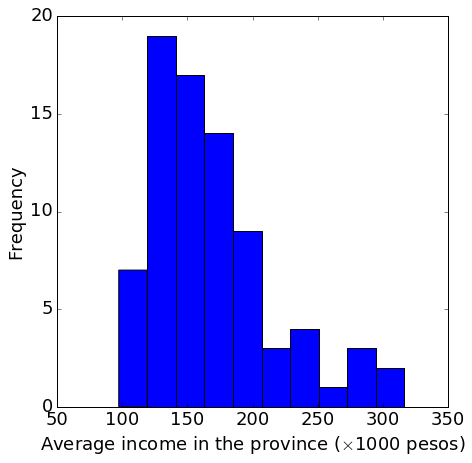

In [107]:
df.gdp_pc_pp.plot.hist(figsize=(7,7))
plt.xlabel("Average income in the province ($\\times$1000 pesos)");

And below is a scatter plot showing average income, poverty incidence, and size (population) of each province

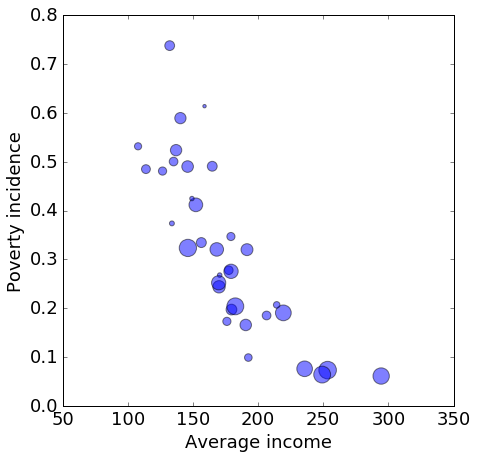

In [143]:
df.plot.scatter(x="gdp_pc_pp", y="pov_head", s=df["pop"]/1e4, alpha=0.5, figsize=(7,7))
plt.xlabel("Average income")
plt.ylabel("Poverty incidence")
plt.ylim(0);

In [169]:
multihazard_info = pd.read_csv("multi_hazard_data.csv", index_col=["province","hazard"])
multihazard_info.head()

fap       far
province         hazard                    
Abra             river   0.188715  0.149419
Agusan Del Norte coast   0.114415  0.091571
                 river   0.365700  0.292684
Agusan Del Sur   coast   0.011681  0.008747
                 river   0.131790  0.098682

# Computing socio-economic capacity

Now that we have minimum familiarity with dataframes, let us use the resilience model. Let us first read the function definitions, from [res_ind_lib.py](res_ind_lib.py)

#### Loading functions

In [161]:
from res_ind_lib import *     #MAIN library: the functions used to compute risk, resilience, etc

#### Defining reference variabes

Before running the model, for technical reasons, we need to define "reference" values for some variables. The following function does it.

In [162]:
df = def_ref_values(df).dropna()
df[["protection", "protectionref"]].head()

,protection,protectionref
province,,
Abra,10.57,10.57
Agusan Del Norte,9.41,9.41
Agusan Del Sur,8.61,8.61
Apayao,6.51,6.51
Batangas,7.73,7.73


#### Assessing risk to assets, capacity and risk to welfare

The function compute_resiliences computes risk and capacity from all the data.

In [163]:
fa_ratios_river  = pd.read_csv("fa_ratios_river.csv", index_col=["province"])
fa_ratios_river.columns=fa_ratios_river.columns.map(float)
fa_ratios_river.columns.name="rp"
fa_ratios_river.head(3)

rp,10.0,100.0
province,,
Abra,1,1.814138
Agusan Del Norte,1,1.081761
Agusan Del Sur,1,1.335951


In [164]:
fa_ratios  = pd.read_csv("fa_ratios.csv", index_col=["province","hazard"]).sortlevel()
fa_ratios.columns=fa_ratios.columns.map(float)
fa_ratios.head()
fa_ratios = fa_ratios.fillna(method="pad",axis=1)
fa_ratios.columns.name="rp"
fa_ratios.head()

rp                       10        100
province         hazard               
Abra             coast     1  1.000000
                 river     1  1.814138
Agusan Del Norte coast     1  1.000000
                 river     1  1.081761
Agusan Del Sur   coast     1  1.000000

In [165]:
df_with_results=compute_resiliences(df, fa_ratios=fa_ratios_river)

#exports the result to a CSV file
df_with_results.to_csv("all_data_and_results.csv")

Let us look at a few inputs and outputs of that function

In [166]:
#set of variable we want to inspect
to_output = ['gdp_pc_pp', 'pop',"protection","fap","far","v_p","v_r","resilience","risk"] 
a=df_with_results[to_output].copy().dropna()

#expresses fractions in %
a.loc[:,["fap","far","v_p","v_r","resilience","risk"]]*=100 

#replaces column names (model variables) by their meaning (human-readable description)
desc=pd.read_csv("inputs/inputs_info.csv").set_index('key')["descriptor"]
a=a.rename(columns=desc)

#exports the result to an Excel file
a.to_excel("results/main results.xlsx")

#displays the first few lines
a.head()

,Average income in the province,Population,Hazard (protection),"Exposure, poor people","Exposure, non-poor people",Asset vulnerability (poor people),Asset vulnerability (non-poor people),Socio-economic capacity,Risk to well-being
province,,,,,,,,,
Abra,133.688,240135.244121,10.57,18.8715,14.941936,15.246329,10,68.808849,1.376363
Agusan Del Norte,179.014,661728.454375,9.41,36.5700,29.268438,36.370003,10,76.239368,2.890419
Agusan Del Sur,126.492,677779.682154,8.61,13.1790,9.868232,29.016559,10,53.505900,1.822861
Apayao,158.732,116022.676390,6.51,0.4600,0.304694,13.193916,10,65.119651,0.043057
Batangas,219.272,2485002.055465,7.73,0.2645,0.221889,23.035679,10,130.239146,0.011436


#### Visualizing risk to assets, capacity and risk to welfare

Now we visualize risk and resilience acrross provinces, with plots and maps

In [167]:
df.head()

,gdp_pc_pp,pop,pov_head,shew,gdp_pc_pp_nat,rel_gdp_pp,share1,axfin_p,axfin_r,social_p,...,T_rebuild_K,pi,nat_buyout,sigma_r,sigma_p,income_elast,rho,protectionref,gdp_pc_pp_ref,v_s
province,,,,,,,,,,,,,,,,,,,,,
Abra,133.688,240135.244121,0.373595,0.953416,184.136685,0.726026,0.374005,0.693233,0.693233,0.408683,...,3,0.2,0.3,0.333333,0.333333,1.5,0.05,10.57,133.688,0.1
Agusan Del Norte,179.014,661728.454375,0.346715,0.821277,184.136685,0.972180,0.279308,0.496880,0.496880,0.388003,...,3,0.2,0.3,0.333333,0.333333,1.5,0.05,9.41,179.014,0.1
Agusan Del Sur,126.492,677779.682154,0.480785,0.821277,184.136685,0.686946,0.395282,0.475969,0.475969,0.388003,...,3,0.2,0.3,0.333333,0.333333,1.5,0.05,8.61,126.492,0.1
Apayao,158.732,116022.676390,0.613667,0.953416,184.136685,0.862034,0.314996,0.261280,0.261280,0.408683,...,3,0.2,0.3,0.333333,0.333333,1.5,0.05,6.51,158.732,0.1
Batangas,219.272,2485002.055465,0.190351,1.117207,184.136685,1.190811,0.228027,0.601054,0.601054,0.362780,...,3,0.2,0.3,0.333333,0.333333,1.5,0.05,7.73,219.272,0.1


Risk to assets averages 1% across the 35 provinces in our sample, ranging from 0.01864% to 3%
Socio-economic capacity averages 92% across our sample, ranging from 38.57001% to 220.08543%
Risk to welfare averages 1% across our sample, ranging from 0.01055% to 3.73193%


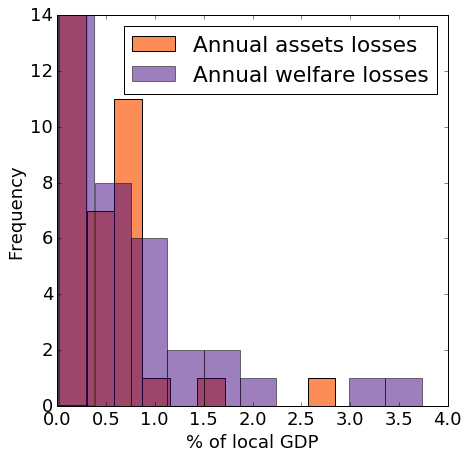

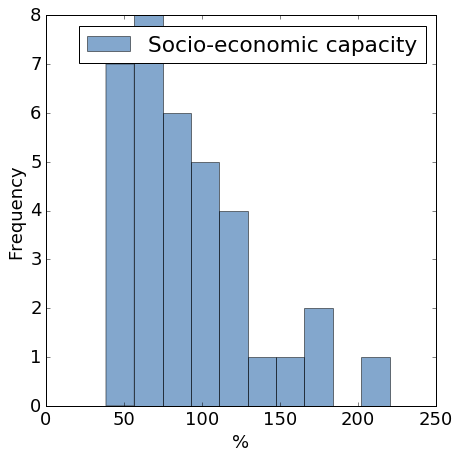

In [170]:
df_with_results=compute_resiliences(df.dropna(), multihazard_data=multihazard_info)

a=df_with_results["risk_to_assets"];
a.min()*100,a.mean()*100,a.max()*100
print("Risk to assets averages {mean:.0%} across the {nb:.0f} provinces in our sample, ranging from {min:.5%} to {max:.0%}".format(
    min=a.min(), nb=a.shape[0],mean=a.mean(),max=a.max()))
ax=(100*a).plot.hist(figsize=(7,7), color="#fc8d59");

a=df_with_results["resilience"];
a.min()*100,a.mean()*100,a.max()*100
print("Socio-economic capacity averages {mean:.0%} across our sample, ranging from {min:.5%} to {max:.5%}".format(
    min=a.min(),mean=a.mean(),max=a.max()))
plt.figure(figsize=(7,7))
ax2=(100*a).plot.hist(alpha=0.5, color="#08519c");
ax2.legend(["Socio-economic capacity"])
ax2.set_xlabel('%');


a=df_with_results["risk"];
a.min()*100,a.mean()*100,a.max()*100
print("Risk to welfare averages {mean:.0%} across our sample, ranging from {min:.5%} to {max:.5%}".format(
    min=a.min(),mean=a.mean(),max=a.max()))
(100*a).plot.hist(alpha=0.5, ax=ax, color="#3f007d");

ax.legend(["Annual assets losses","Annual welfare losses"])
ax.set_xlabel('% of local GDP');

Risk to assets, socio-economic capacity, and total welfare risk can also be visualized in maps (see [draw_maps.ipynb](draw_maps.ipynb) for how to build these maps)

 <table border="0" style="border:none">
  <tr>
  <td>**Risk to assets**</td>
    <td>**Socio-economic capacity**</td>
    <td>**Risk to welfare**</td>
  </tr>
  <tr>
    <td>![title](img/map_and_legend_of_asset_risk.png)</td>
    <td>![title](img/map_and_legend_of_se_capacity.png)</td>
    <td>![title](img/map_and_legend_of_welfare_risk.png)</td>
  </tr>
</table> 


# Categorizing provinces

Here we categorize provinces in 3 tiers (Low, mid, high) according to their ranking on socio-econic capacity and on overall risk to welfare. We use the functions `make_tiers` and `categories_to_formated_excel_file` from [res_ind_lib.py](res_ind_lib.py)

In [118]:
categories = pd.DataFrame([make_tiers(df_with_results.resilience), make_tiers(df_with_results.risk)]).T.dropna()
categories_to_formated_excel_file(categories,"categories.xlsx")
categories.rename(columns=desc).head()

,Socio-economic capacity,Risk to well-being
Abra,Mid,High
Agusan Del Norte,Mid,High
Agusan Del Sur,Low,High
Apayao,Low,Low
Batangas,High,Low


# Policy experiments

Finally, the resilience indicator model can be used to asses the impact of specific policies on asset and welfare losses. In the following we provide two examples.

#### Impact of decreasing poverty incidence

In [119]:
df_share1 = compute_resiliences( def_ref_values(df.dropna().assign(pov_head=df.pov_head-5/100) ))

#welfare losses
wa=df_with_results.total_equivalent_cost.sum()*1e-6
wb=df_share1.total_equivalent_cost.sum()*1e-6

#asset losses
ka = (df_with_results.dKtot/df.protection).sum()*1e-6
kb = (df_share1.dKtot/df_share1.protection).sum()*1e-6

nb_countries_all_results = df_with_results["resilience"].dropna().shape[0]

print(" Decreasing poverty incidence by 1 percent in the {nb} provincies \
would increase asset losses from USD {ka:0.2f} to {kb:0.2f} billions per year\
({XX:.1%}), but reduce welfare losses by {YY:.1%}".format(
        XX=(kb-ka)/ka,ka=ka,kb=kb,YY=(wa-wb)/wa,nb=nb_countries_all_results)
     )

 Decreasing poverty incidence by 1 percent in the 35 provincies would increase asset losses from USD 28.14 to 27.26 billions per year(-3.1%), but reduce welfare losses by 8.6%


#### Impact of increasing effective scale up

In [120]:
df_su = compute_resiliences( df.dropna().assign(sigma_p=1) )

#welfare losses
wa=df_with_results.total_equivalent_cost.sum()*1e-6
wb=df_su.total_equivalent_cost.sum()*1e-6

#asset losses
ka = (df_with_results.dKtot/df.protection).sum()*1e-6
kb = (df_su.dKtot/df_su.protection).sum()*1e-6

print(" Increasing effective scale up to 100% in the {nb} provincies \
would left asset losses unchanged (from {ka:0.2f} to {kb:0.2f} billions per year), \
but reduce welfare losses by {YY:.0%}".format(
        XX=100*(kb-ka)/ka,ka=ka,kb=kb,YY=(wa-wb)/wa,nb=nb_countries_all_results)
     )

 Increasing effective scale up to 100% in the 35 provincies would left asset losses unchanged (from 28.14 to 28.14 billions per year), but reduce welfare losses by 39%
